# Reddit Scraper and NLP Analysis

This notebook is written as a practice in **web scraping**, this could be done by accessing the Reddit API, but a conscious decision was made to scrape data instead as an exercise.

## Import libraries and set up html request function for scraping

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
#html request
def html_data(url):
    html = requests.get(url, headers = {'User-Agent': 'whatever'})
    soup = BeautifulSoup(html.text, 'lxml')
    threads = soup.find_all(name = 'div', attrs = {'id':'siteTable','class':'sitetable linklisting'})
    status_code = html.status_code
    
    return status_code, threads, soup

## Create functions for scraping reddit front page

In [3]:
def get_titles(threads, titles):
    for i in threads:
        x = i.find_all(name = 'p', attrs = {'class':'title'})
        for t in x:
               titles.append(t.a.text) 
    return titles
            
def get_subreddits(threads, subreddit):
    for i in threads:
        x = i.find_all(name = 'p', attrs = {'class':'tagline'})
        for t in x:
            subreddit.append(t.find('a', attrs = {'class':'subreddit hover may-blank'}).text)
    return subreddit

def get_dates(threads, dates):
    for i in threads:
        x = i.find_all(name = 'p', attrs = {'class':'tagline'})
        for d in x:
            dates.append(d.find(name = 'time')['datetime'])
    return dates

def get_vids(threads, vids):
    for i in threads:
        x = i.find_all(name = 'div', attrs = {'class':'top-matter'})
        for d in x:
            if d.find(name = 'div', attrs = {'class':'expando-button collapsed hide-when-pinned video'}) != None:
                vids.append(1)
            else:
                vids.append(0)
    return vids
    
def get_thread_url(threads, threadlink):
    for i in threads:
        x = i.find_all(name = 'p', attrs = {'class':'title'})
        for t in x:
               threadlink.append(t.a['href'])
    return threadlink
    
def get_comments(threads, comments):
    for i in threads:
        x = i.find_all(name = 'li', attrs = {'class':'first'})
        for j in x:
            comments.append(j.find(name = 'a').text.split()[0])
    return comments

#if no likes return NaN, process this with Pandas later(likely remove)
def get_likes(threads, likes):
    for i in threads:
        x = i.find_all(name = 'div', attrs = {'class':'score unvoted'})
        for j in x:
            try:
                likes.append(j['title'])
            except:
                likes.append('NaN')
    return likes

def get_thread_id(threads, thread_id):
    for i in threads:
        x = i.find_all(name = 'div', attrs = {'data-type':'link'})
        for j in x:
            thread_id.append(j['class'][2].split('-')[-1])
    return thread_id

## Define function to scrape and consolidate data into pandas dataframe

In [4]:
#scrape the data
def getFrontPageData(pages = 5, reddit_site = 'https://www.reddit.com'):
    '''Web scrapes reddit for front page data, you can input how many pages you want to return.
       If this number exceeds the total number of pages available the function will return all results.
       
       If the scraper crashes when attempting to reach the next page it will output the current results
       of the dataframe. If you need to pick up at a later time you can input the url you want to start 
       at by using the url kwarg.'''
    
    #create lists/dict for information we gonna scrape
    titles, subreddit, dates, threadlink, vids, comments, likes, thread_id = ([] for i in range(8))
    red_dict = {}
    
    #keeps track of results per page
    page_cnt = 0
    url = reddit_site 
    
    for page in range(0, pages):
        
        #catch soup and data about trending threads
        status_code, threads, soup = html_data(url)
        
        try:
            #while the html request is good, use this to determine how fast you can request data from server
            status_code == 200
        except:
            break

        #try to get data, end function if error
        try:
            titles = get_titles(threads, titles)
            subreddit = get_subreddits(threads, subreddit)
            dates = get_dates(threads, dates)
            threadlink = get_thread_url(threads, threadlink)
            vids = get_vids(threads, vids)
            comments = get_comments(threads, comments)
            likes = get_likes(threads, likes)
            thread_id = get_thread_id(threads, thread_id)
        except:
            print("Getting Data Error!")
            break

        #get hyperlink for next page, if not available this is the end of the front page, end script
        #by breaking out of for loop and creating the dataframe, increase page count by 25
        try:
            page_cnt += 25
            for i in threads:
                x = i.find(name = 'div', attrs = {'data-type':'link', 'data-rank':page_cnt})['class'][2].split('-')[-1]
            url = reddit_site + '/?count=' + str(page_cnt) + '&after=' + str(x)
        except:
            print("Next Page Error!")
            break
        #wait some time, get next page data
        time.sleep(0.1)
    
    #create dictionary from lists for creating df
    red_dict['title'] = titles
    red_dict['subreddit'] = subreddit
    red_dict['submitted'] = dates
    red_dict['threadlink'] = threadlink
    red_dict['comments'] = comments
    red_dict['expands'] = vids
    red_dict['likes'] = likes
    red_dict['thread_id'] = thread_id

    #printing information where scrape ends
    print("Scraped results for", page + 1, "reddit page(s)")
    print("Returned", len(titles), "thread results")
    print("Last Status Code:", status_code)
    print("Last scraped Reddit page:", url)
    
    #return df to begin analysis
    return pd.DataFrame(red_dict)

## Scrape Reddit and return results as a pandas dataframe for homepage and r/all, consolidate results into one dataframe

In [5]:
%%time
#get data from front page and from r/all to get a sample of viral posts(front page) and non-viral(other stuff in r/all)
redall = getFrontPageData(pages= 10000, reddit_site = 'https://www.reddit.com/r/all')
redhome = getFrontPageData(pages = 10000, reddit_site = 'https://www.reddit.com')

Next Page Error!
Scraped results for 319 reddit page(s)
Returned 7950 thread results
Last Status Code: 200
Last scraped Reddit page: https://www.reddit.com/r/all/?count=7950&after=t3_80eufz
Next Page Error!
Scraped results for 53 reddit page(s)
Returned 1308 thread results
Last Status Code: 200
Last scraped Reddit page: https://www.reddit.com/?count=1300&after=t3_8098fu
Wall time: 5min 50s


In [6]:
#deduplicating file based on id of the thread
redhome.drop_duplicates(subset = 'thread_id', inplace = True)
redall.drop_duplicates(subset = 'thread_id', inplace = True)

In [7]:
#mark posts in r/all that that were present on the front page
redall['frontpage'] = redall['thread_id'].apply(lambda x: 1 if x in list(redhome['thread_id']) else 0 )
#deleting pages from frontpage in r/all
redall.drop(redall[redall['frontpage'] == 1].index, axis = 0, inplace = True)

In [8]:
#mark all homepage posts as 1(viral), and all remaining r/all as 0(non-viral)
redhome['frontpage'] = 1
#concatenate the two datasets into one set, reset the index, drop the old index
reddit = pd.concat([redall, redhome]).reset_index(drop = True)

In [9]:
#drop pages where comments was scraped incorrectly and convert to number
reddit.drop(reddit[reddit['comments'] == 'comment'].index, inplace = True)
reddit['comments'] = pd.to_numeric(reddit['comments'])

In [10]:
#drop threads where likes did not come in correctly
reddit.drop(reddit[reddit['likes'] == 'NaN'].index, inplace = True)
#convert likes to numeric
reddit['likes'] = pd.to_numeric(reddit['likes'])

In [11]:
#column for if comments is above or below the average number of comments
reddit['comments_relation'] = reddit['comments'].apply(lambda x: 1 if x >= np.average(reddit['comments']) else 0)

In [40]:
#get Part-of-Speech (POS) tagging for each word in title in new column
reddit['POS'] = reddit['title'].apply(lambda x: [ token.tag_ for token in nlp(x)])
reddit['POS_sen'] = reddit['POS'].apply(lambda x: " ".join(i for i in x))

In [55]:
#get entity recognition token
reddit['ent'] = reddit['title'].apply(lambda x: [token.label_ for token in nlp(x).ents])
#entity sentence to count vectorize
reddit['ent_sen'] = reddit['ent'].apply(lambda x: " ".join(i for i in x))

In [244]:
inputs = reddit['title']

In [245]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

In [246]:
#instantiate model and fit_transform on our homepage data
#thread_id is used here as the index so other columns can be merged on to it as a unique identifier

cvec = CountVectorizer(stop_words = 'english', ngram_range=(1,2))

cvecdf = pd.DataFrame(cvec.fit_transform(inputs).todense(), 
                     columns = cvec.get_feature_names(),
                     index = reddit['thread_id']).reset_index()



In [176]:
tvec = TfidfVectorizer(stop_words = 'english', ngram_range = (1,2))

tvecdf  = pd.DataFrame(tvec.fit_transform(inputs).todense(),
                       columns=tvec.get_feature_names(),
                      index = reddit['thread_id']).reset_index()

## Create Train and Test Data

In [200]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [247]:
#merge count verctorized/tfidf data together with other necessary features
cvecdfy = cvecdf.merge(reddit[['thread_id', 'expands', 'comments_relation']], how = 'left', on = 'thread_id')
#tvecdfy= tvecdf.merge(reddit[['thread_id', 'expands', 'comments_relation']], how = 'left', on = 'thread_id')


In [248]:
#cvecdfy = tvecdfy.merge(pd.get_dummies(tvecdfy['subreddit'], prefix = 'SR', drop_first = True), how = 'left', left_index = True, right_index = True)

In [249]:
#set x and y before putting into test, train, split
y = cvecdfy['comments_relation']
X = cvecdfy.drop(columns = ['thread_id', 'comments_relation'])

In [250]:
#splits into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5
                                                   , random_state = 13
                                                   , stratify = y)


### Downsample majority class to provide equal distribution of classes for training data

In [251]:
#baseline accuracy calculation, at this point the model is performing worse than just picking 
#must downsample to get an even distribution of classes for training
1 - cvecdfy['comments_relation'].sum()/cvecdfy.shape[0]

0.8298847177061779

In [252]:
#rejoin train data so it can be downsampled to match classes
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)

#downsample the majority class (posts with comments under average, to make evenly stratified train data)
#separate minority and majority classes
train_majority = traindata[traindata['comments_relation'] == 0]
train_minority = traindata[traindata['comments_relation'] == 1]
#downsample majority class
train_majority_downsampled = resample(train_majority, 
                                     replace = False, 
                                     n_samples = train_minority.shape[0],
                                     random_state = 42)
#combine classes
train_data_downsampled = pd.concat([train_minority, train_majority_downsampled])
#split back into X_train and y_train
X_train = train_data_downsampled.drop(columns = 'comments_relation')
y_train = train_data_downsampled['comments_relation']

## Run Models with GridSearch to find optimal hyperparamaters

In [253]:
X_train.shape

(1152, 41975)

In [254]:
#setting up stratified kfold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)


In [255]:
%%time

bparams = {'n_estimators':[20, 21, 22, 23, 24],
            'max_features':[10, 20, 30, 35, 38, 40, 41]}

bgs = GridSearchCV(BaggingClassifier(),
                   bparams,
                   verbose = 1, 
                   cv = cv,
                   n_jobs = -1)

bgs.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  2.2min finished


Wall time: 2min 13s


In [256]:
bgs.score(X_test, y_test)

0.189476795743423

In [257]:
%%time

rfparams = {'n_estimators':[20, 21, 22, 23, 24],
            'max_features':[30, 35, 38, 40],
            'min_samples_leaf':[2,3,5,7,9,11]}

rfgs = GridSearchCV(RandomForestClassifier(),
                    rfparams,
                    verbose = 1,
                    cv = cv,
                    n_jobs = -1)

rfgs.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.7min finished


Wall time: 7min 44s


In [258]:
rfgs.score(X_test, y_test)

0.16996748448122967

In [265]:
rfgs.score(X_train, y_train)

0.5

In [266]:
confusion_matrix(np.array(y_train), rfgs.best_estimator_.predict(X_train), labels = [1,0])

array([[576,   0],
       [576,   0]], dtype=int64)

In [259]:
%%time

etparams = {'n_estimators':[22, 23, 24, 25, 30],
            'max_features':[20, 30, 35],
            'min_samples_leaf':[2,3,5,7,8,9,10,11]}


etgs = GridSearchCV(ExtraTreesClassifier(),
                      etparams,
                      verbose = 1,
                      cv = cv,
                      n_jobs = -1)

etgs.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.7min finished


Wall time: 7min 40s


In [260]:
etgs.score(X_test, y_test)

0.8066804611291752

In [272]:
confusion_matrix(np.array(y_train), etgs.best_estimator_.predict(X_train), labels = [1,0])

array([[ 65, 511],
       [  9, 567]], dtype=int64)

### Looking at feature importance

In [105]:
feats = pd.concat([pd.DataFrame(X_train.columns.tolist()),pd.DataFrame(rfgs.best_estimator_.feature_importances_)],axis = 1)
feats.columns = ['feature', 'importance']

## Results

In [82]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [108]:
etgs.fit(X_train, y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed: 22.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 15, 20, 21, 22, 23, 24], 'min_samples_leaf': [2, 3, 5, 7, 9, 11], 'max_features': [10, 20, 30, 35, 38, 40, 41]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [306]:
#determine false positives and true positives
fpr, tpr, _ = roc_curve(y_test, etgs.best_estimator_.predict_proba(X_test)[:,0])

In [307]:
#calculate the AUC (area under the curve)
roc_auc = auc(fpr, tpr)

In [309]:
print('ROC AUC:', format(roc_auc,  '.2f'))

ROC AUC: 1.00


In [310]:
confusion_matrix(np.array(y_test), etgs.predict(X_test), labels = [1,0])

array([[  29,  546],
       [ 108, 2700]], dtype=int64)

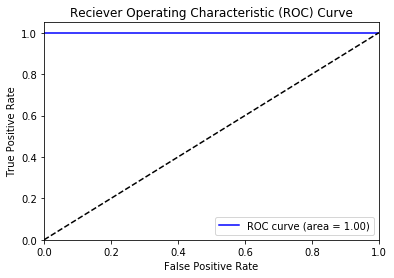

In [311]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()